In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.decomposition import PCA

In [2]:
def load_data():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.view(-1))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    x_train_raw = train_dataset.data.numpy()
    x_test_raw = test_dataset.data.numpy()

    # Flatten to a 2D array where each row is a pixel (28*28 = 784 pixels) for a given image
    x_train_reshaped = x_train_raw.reshape(-1, 784)
    x_test_reshaped = x_test_raw.reshape(-1, 784) 

    # Normalize data between 0 and 1 (For Sigmoid & PCA later on)
    x_train_normalized = x_train_reshaped / 255.0
    x_test_normalized = x_test_reshaped / 255.0 

    # Convert to tensor
    x_train_tensor = torch.tensor(x_train_normalized, dtype=torch.float32), 
    x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

    return x_train_tensor[0], x_test_tensor[0]

X_train, _ = load_data()
X_train = X_train

# Create DataLoaders for batch processing
train_loader = DataLoader(TensorDataset(X_train), batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12578631.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 338319.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3166074.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2061076.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class Autoencoder(nn.Module): 
    def __init__(self): 
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),  # N, 784 -> N, 512
            nn.ReLU(), 
            nn.Linear(512, 256),
            nn.ReLU(), 
            nn.Linear(256, 128)  # N, 256 -> N, 128
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),  # N, 128 -> N, 256
            nn.ReLU(), 
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()  # N, 128 -> N, 784
        )

    def forward(self, X): 
        latent = self.encoder(X)
        reconstructed = self.decoder(latent)

        return reconstructed, latent

In [6]:
# Training loop parameters
num_epochs = 100  # To speed up training, can change to 100
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
def train(model, dataloader, criterion, optimizer): 
    train_loss_per_epoch = []
    latent_codes = []
    reconstructed_samples = []  # Store reconstructed outputs (subset)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        
        for i, batch in enumerate(dataloader):
            inputs, = batch  # Unpack the batch 
            
            # Forward pass to get the reconstructed output and latent codes
            reconstructed, latent = model(inputs)
            latent_codes.append(latent)

            # Save reconstructed outputs for visualization
            if epoch == num_epochs - 1 and i == 0:  # Only save first batch in the last epoch
                reconstructed_samples = reconstructed.detach().cpu()
                original_samples = inputs.detach().cpu()

            # Calculate the loss
            loss = criterion(reconstructed, inputs)  # MSE between reconstructed output and input
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Average loss over all samples
        train_loss_per_epoch.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_per_epoch[-1]:.4f}")

    return train_loss_per_epoch, latent_codes, original_samples, reconstructed_samples


train_loss_per_epoch, latent_codes, original, reconstructed = train(model, train_loader, criterion, optimizer)

Epoch 1/100, Loss: 9.4982
Epoch 2/100, Loss: 6.7351
Epoch 3/100, Loss: 5.9829
Epoch 4/100, Loss: 5.5970
Epoch 5/100, Loss: 5.3066
Epoch 6/100, Loss: 5.0549
Epoch 7/100, Loss: 4.7638
Epoch 8/100, Loss: 4.7032
Epoch 9/100, Loss: 4.5221
Epoch 10/100, Loss: 4.4705
Epoch 11/100, Loss: 4.2865
Epoch 12/100, Loss: 4.1748
Epoch 13/100, Loss: 4.1666
Epoch 14/100, Loss: 4.0224
Epoch 15/100, Loss: 3.9938
Epoch 16/100, Loss: 3.9621
Epoch 17/100, Loss: 3.9003
Epoch 18/100, Loss: 3.8485
Epoch 19/100, Loss: 3.8489
Epoch 20/100, Loss: 3.7830
Epoch 21/100, Loss: 3.8006
Epoch 22/100, Loss: 3.7577
Epoch 23/100, Loss: 3.8696
Epoch 24/100, Loss: 3.7676
Epoch 25/100, Loss: 3.7010
Epoch 26/100, Loss: 3.6488
Epoch 27/100, Loss: 3.6308
Epoch 28/100, Loss: 3.6528
Epoch 29/100, Loss: 3.6331
Epoch 30/100, Loss: 3.6606
Epoch 31/100, Loss: 3.6111
Epoch 32/100, Loss: 3.5998
Epoch 33/100, Loss: 3.6174
Epoch 34/100, Loss: 3.6271
Epoch 35/100, Loss: 3.5586
Epoch 36/100, Loss: 3.5903
Epoch 37/100, Loss: 3.5466
Epoch 38/1

In [8]:
def preprocess_latent_codes(latent_codes):
    # Concatenate the list of tensors into a single tensor along the first dimension
    latent_tensor = torch.cat(latent_codes, dim=0)
    # Convert the tensor to a NumPy array
    return latent_tensor.detach().cpu().numpy()

processed_latent_codes = preprocess_latent_codes(latent_codes)

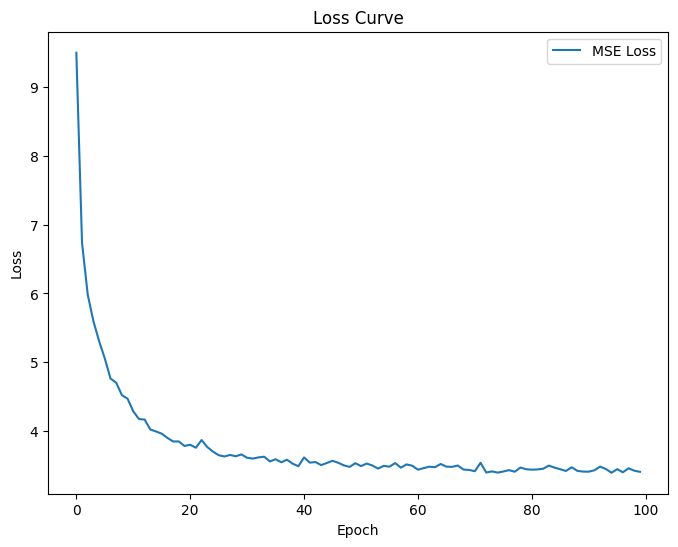

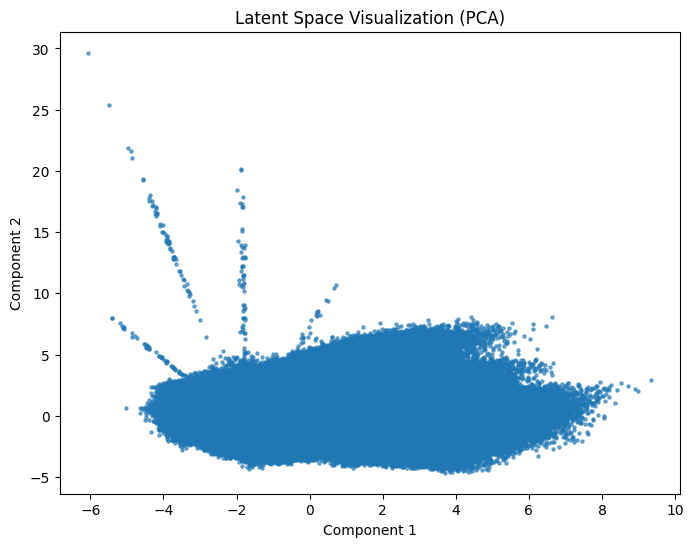

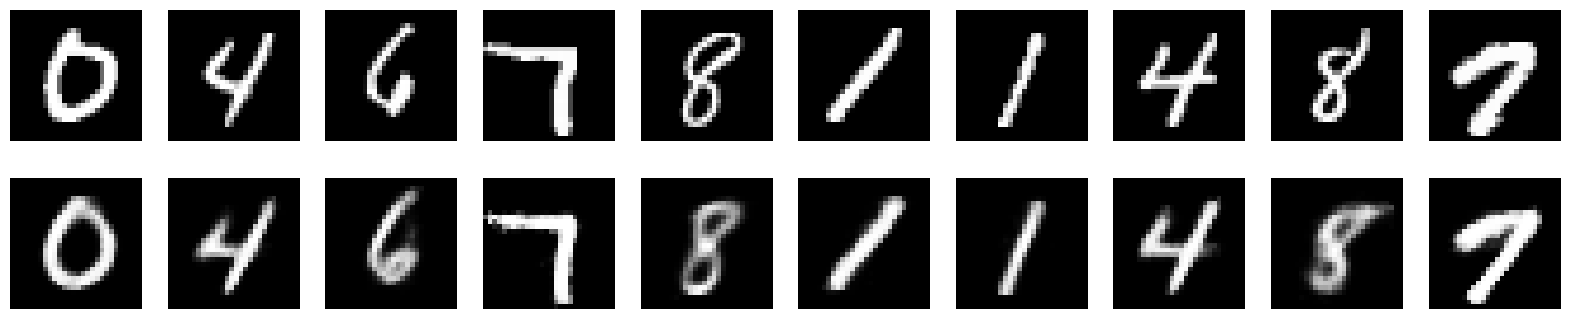

In [9]:
# 8. Plot the loss curve
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Uncomment after training to plot the loss curve
plot_loss_curve(train_loss_per_epoch)

# 9. Visualize latent codes using PCA
def visualize_latent_space(latent_codes):
    pca = PCA(n_components=2)
    reduced_codes = pca.fit_transform(latent_codes)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_codes[:, 0], reduced_codes[:, 1], s=5, alpha=0.6)
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Uncomment after training to visualize latent space
visualize_latent_space(processed_latent_codes)

# 10. Show original and reconstructed images side by side
def show_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Uncomment after training to show images
show_images(original, reconstructed)